In [16]:
import pandas
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,v2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
# import wandb
# wandb.login()
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="Handwriting Recognition",

#     # track hyperparameters and run metadata
#     config={
#         "learning_rate": 1e-4,
#         "architecture": "ResNet",
#         "dataset": "MNIST",
#         "epochs": 10,
#         "batch_size": 512,
#         "Loss function": "SGD"
#     }
# )


In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

In [113]:
transform_compose = v2.Compose([
    v2.RandomAdjustSharpness(2),
    v2.RandomHorizontalFlip(p=0.3),
    v2.RandomRotation(degrees=15),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((28, 28)),
    v2.ToTensor(),
    v2.Normalize((0.5,), (0.5,))
])

/Users/nilaygaitonde/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [114]:
batch_size = 512
symbols_dataset = datasets.ImageFolder(
    "/Users/nilaygaitonde/Documents/Projects/Maths/datasets/archive/extracted_images"
)
mnist_train_dataset = torchvision.datasets.MNIST('./datasets/', train=True, download=True)
mnist_test_dataset = torchvision.datasets.MNIST('./datasets/', train=False, download=True)

In [115]:
class CombinedDataset(Dataset):
    def __init__(self, mnist, symbols,transform=None):
        self.mnist = mnist
        self.symbols = symbols
        self.classes = [x.split()[0] for x in mnist.classes] + symbols.classes
        self.transform = transform

    def __getitem__(self, index):
        if index < len(self.mnist):
            img,label = self.mnist[index]
        else:
            img,label= self.symbols[index - len(self.mnist)]
            img = img.convert('L')
            img = img.point(lambda p: p < 128 and 255)
            label+=10
        
        if self.transform:
            img = self.transform(img)
            # img = cv2.bitwise_not(np.array(img))
        
        return img,label

    def __len__(self):
        return len(self.mnist) + len(self.symbols)
    
    def class_to_index(self,idx):
        return self.classes[idx]
combinedDataset = CombinedDataset(mnist_train_dataset, symbols_dataset,transform=transform_compose)
train_size = int(0.8 * len(combinedDataset))
val_size = len(combinedDataset) - train_size
train_dataset, val_dataset = random_split(combinedDataset, [train_size, val_size])
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [112]:
combinedDataset.classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '!',
 '(',
 ')',
 '+',
 ',',
 '-']

-


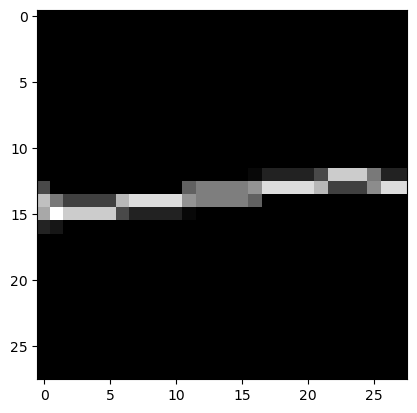

In [122]:
index = 23
print(combinedDataset.classes[train_dataset[index][1]])
plt.imshow(train_dataset[index][0].squeeze(), cmap='gray')

In [26]:
class EarlyStopping():
    def __init__(self,threshold=0.01,patience=3):
        self.threshold = threshold
        self.patience = patience
        self.counter = 0
        self.prev_loss = None
        self.best_loss = None
    
    def __call__(self,loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss > self.threshold:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter == self.patience:
            return True
        return False
earlystopper = EarlyStopping(threshold=0.1,patience=5)

In [116]:
class HandwritingRecogniser(nn.Module):
    """
    Input Shape: (28,28)
    Output classes: 9
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding="same"), #(32,28,28)
            nn.BatchNorm2d(32), #(32,28,28)
            nn.ReLU() 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding="same"), #(64,28,28)
            nn.BatchNorm2d(64), #(64,28,28)
            nn.ReLU()
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=1,padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=1,padding="same"),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding="same"), #(128,28,28)
            nn.BatchNorm2d(128), #(128,28,28)
            nn.MaxPool2d(2), # (128,14,14)
            nn.ReLU()
        )
        self.classification = nn.Sequential(
            nn.Flatten(), #(1,25088)
            nn.Linear(in_features=25088,out_features=1024,bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024,out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256,out_features=10),
            nn.Softmax(dim=1)
        )
    def forward(self,X):
        out = self.conv1(X)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        logits = self.classification(out)
        return logits

In [117]:
class ExtendedHandwrittingRecognition(nn.Module):
    def __init__(self,base_model,num_classes):
        super().__init__()
        self.conv1 = base_model.conv1
        self.conv2 = base_model.conv2
        self.res1 = base_model.res1
        self.conv3 = base_model.conv3
        self.classification = nn.Sequential(
            nn.Flatten(), #(1,25088)
            nn.Linear(in_features=25088,out_features=1024,bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024,out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256,out_features=num_classes),
            nn.Softmax(dim=1)
        )

        for params in self.conv1.parameters():
            params.requires_grad = False
        for params in self.conv2.parameters():
            params.requires_grad = False
        for params in self.res1.parameters():
            params.requires_grad = False
        for params in self.conv3.parameters():
            params.requires_grad = False
        
    
    def forward(self,X):
        out = self.conv1(X)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        logits = self.classification(out)
        return logits

In [118]:
def accuracy(true_y, pred_y):
    return (true_y == pred_y).float().mean()
def train_epoch(model, device, loss_fn,optimizer, X,y):
    logits = model(X)
    loss = loss_fn(logits, y)
    y_pred = torch.argmax(logits,dim=1)
    acc = accuracy(y,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # wandb.log({"Loss": loss.item(),"Accuracy": acc.item()})
    return loss, logits,acc
    
def training_loop(dataset,n_epochs, model, device, loss_fn, optimizer,batch_interval=10,epoch_interval=1):
    for epoch in range(n_epochs):
        for i, (X,y) in enumerate(dataset):
            X = X.to(device)
            y = y.to(device)
            loss,logits,acc = train_epoch(model,device,loss_fn,optimizer,X,y)
            # break
            if i % batch_interval == 0:
                print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss} , Accuracy: {acc}")
        if epoch % epoch_interval == 0:
            print(f"Epoch: {epoch}, Loss: {loss}")

In [120]:
n_epochs = 10
lr = 1e-4
base_model = HandwritingRecogniser()
base_model.load_state_dict(torch.load("app/ai/models/model4.pth"))
model = ExtendedHandwrittingRecognition(base_model,len(combinedDataset.classes)).to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
training_loop(train_data,n_epochs,model,device,loss_fn,optimizer)

Epoch: 0, Batch: 0, Loss: 2.7733380794525146 , Accuracy: 0.05859375
Epoch: 0, Batch: 10, Loss: 2.3093676567077637 , Accuracy: 0.5859375
Epoch: 0, Batch: 20, Loss: 2.1874818801879883 , Accuracy: 0.720703125
Epoch: 0, Batch: 30, Loss: 2.1729185581207275 , Accuracy: 0.712890625
Epoch: 0, Batch: 40, Loss: 2.133068561553955 , Accuracy: 0.759765625
Epoch: 0, Batch: 50, Loss: 2.071077823638916 , Accuracy: 0.81640625
Epoch: 0, Batch: 60, Loss: 2.0535759925842285 , Accuracy: 0.8359375
Epoch: 0, Batch: 70, Loss: 2.0450971126556396 , Accuracy: 0.83984375
Epoch: 0, Batch: 80, Loss: 2.027484893798828 , Accuracy: 0.8515625
Epoch: 0, Batch: 90, Loss: 2.040503978729248 , Accuracy: 0.845703125
Epoch: 0, Batch: 100, Loss: 2.0341806411743164 , Accuracy: 0.849609375
Epoch: 0, Batch: 110, Loss: 2.003709316253662 , Accuracy: 0.875
Epoch: 0, Batch: 120, Loss: 2.0353736877441406 , Accuracy: 0.84375
Epoch: 0, Batch: 130, Loss: 2.023282289505005 , Accuracy: 0.853515625
Epoch: 0, Batch: 140, Loss: 2.020063400268

In [107]:
def test_model(model,device):
    model.eval()
    with torch.no_grad():
        for i, (X,y) in enumerate(val_data):
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            y_pred = torch.argmax(logits,dim=1)
            acc = accuracy(y,y_pred)
            print(f"Batch: {i}, Accuracy: {acc}")
test_model(model,device)

Batch: 0, Accuracy: 0.974609375
Batch: 1, Accuracy: 0.98046875
Batch: 2, Accuracy: 0.96875
Batch: 3, Accuracy: 0.9765625
Batch: 4, Accuracy: 0.986328125
Batch: 5, Accuracy: 0.97265625
Batch: 6, Accuracy: 0.978515625
Batch: 7, Accuracy: 0.978515625
Batch: 8, Accuracy: 0.9765625
Batch: 9, Accuracy: 0.9765625
Batch: 10, Accuracy: 0.978515625
Batch: 11, Accuracy: 0.970703125
Batch: 12, Accuracy: 0.974609375
Batch: 13, Accuracy: 0.978515625
Batch: 14, Accuracy: 0.974609375
Batch: 15, Accuracy: 0.96875
Batch: 16, Accuracy: 0.96875
Batch: 17, Accuracy: 0.98046875
Batch: 18, Accuracy: 0.9765625
Batch: 19, Accuracy: 0.982421875
Batch: 20, Accuracy: 0.978515625
Batch: 21, Accuracy: 0.978515625
Batch: 22, Accuracy: 0.984375
Batch: 23, Accuracy: 0.962890625
Batch: 24, Accuracy: 0.974609375
Batch: 25, Accuracy: 0.97265625
Batch: 26, Accuracy: 0.96875
Batch: 27, Accuracy: 0.96484375
Batch: 28, Accuracy: 0.97265625
Batch: 29, Accuracy: 0.97265625
Batch: 30, Accuracy: 0.978515625
Batch: 31, Accuracy: 

In [121]:
torch.save(model.state_dict(),"app/ai/models/combinedModel2.pth")

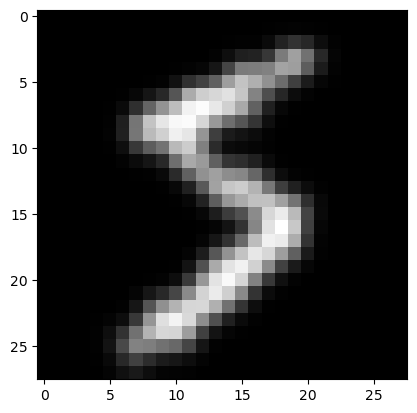

In [50]:
plt.imshow(train_dataset[0][0][0].numpy(),cmap="gray")

In [13]:
plt.imsave("app/ai/imgs/sample.png",train_dataset[0][0][0].numpy(),cmap='gray')

5


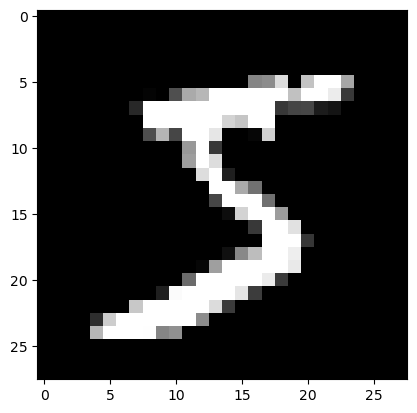

In [11]:
plt.imshow(train_dataset[0][0][0],cmap='gray')
print(train_dataset[0][1])

(4, 4)

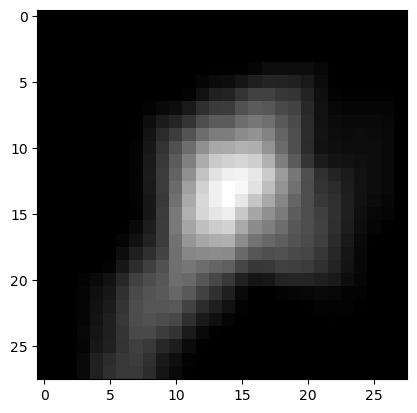

In [33]:
model = HandwritingRecogniser().to(device)
model.load_state_dict(torch.load("app/ai/models/model4.pth"))
model.eval()
idx = 53
plt.imshow(train_dataset[idx][0][0],cmap='gray')
model(train_dataset[idx][0].unsqueeze(0).to(device)).argmax().item(),train_dataset[idx][1]

'sub'

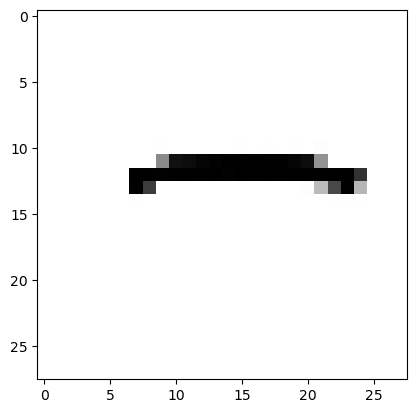

In [36]:
index = 32
plt.imshow(train_dataset[index][0][0],cmap='gray')
reverse_classes[model(train_dataset[index][0].unsqueeze(0).to(device)).argmax().item()]

In [41]:
reverse_classes[7]

'8'

In [40]:
print(train_dataset[index][0][0].numpy())

[[ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.  

In [26]:
data = train_dataset[0][0].unsqueeze(0).to(device)
model(data).argmax().item()

/Users/nilaygaitonde/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


5

16 0 16 45


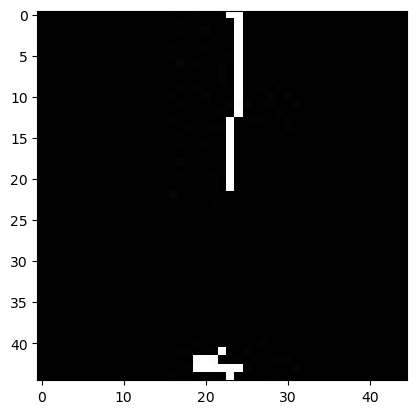

In [72]:
img = cv2.imread("datasets/archive/extracted_images/!/!_7731.jpg",cv2.IMREAD_GRAYSCALE)
img = 255 - img
plt.imshow(img,cmap='gray')
# invert the image it has white background and black text
plt.imshow(img,cmap='gray')
coords = cv2.findNonZero(img)
x,y,w,h = cv2.boundingRect(coords)
cropped = img[y:y+h,x:x+w]
# plt.imshow(cropped,cmap='gray')
print(x,y,w,h)

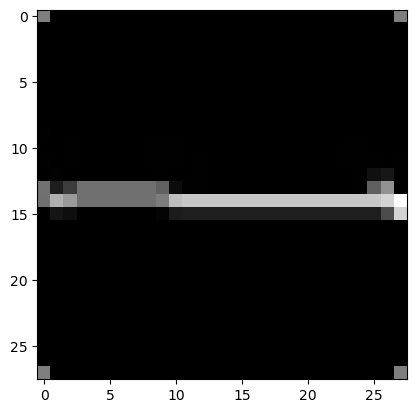

In [65]:
plt.imshow(bleh,cmap='gray')